In [1]:
import zipfile, os

# Path to your uploaded zip
zip_path = "archive(1).zip"

# Extract to a folder named "dataset"
extract_path = "dataset"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Extracted to:", os.path.abspath(extract_path))


✅ Extracted to: C:\Users\VSR BALASUBRAHMANYAM\dataset


In [52]:
import os
import tensorflow as tf
from tensorflow import keras

# Correct dataset path
DATA_DIR = r"dataset/final"

print("Files/folders inside DATA_DIR:", os.listdir(DATA_DIR))
print("Train folder:", os.listdir(os.path.join(DATA_DIR, "train")))
print("Val folder:", os.listdir(os.path.join(DATA_DIR, "val")))
print("Test folder:", os.listdir(os.path.join(DATA_DIR, "test")))

Files/folders inside DATA_DIR: ['test', 'train', 'val']
Train folder: ['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']
Val folder: ['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']
Test folder: ['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']


In [53]:
img_size = (224, 224)
batch_size = 32

train_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "train"),
    image_size=img_size,
    batch_size=batch_size
)

val_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "val"),
    image_size=img_size,
    batch_size=batch_size
)

test_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=img_size,
    batch_size=batch_size
)

Found 17728 files belonging to 8 classes.
Found 2529 files belonging to 8 classes.
Found 5075 files belonging to 8 classes.


In [54]:
AUTOTUNE = tf.data.AUTOTUNE

def preprocess(img, label):
    return tf.cast(img, tf.float32) / 255.0, label

train_ds = train_ds.map(preprocess).cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.map(preprocess).cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.map(preprocess).cache().prefetch(buffer_size=AUTOTUNE)

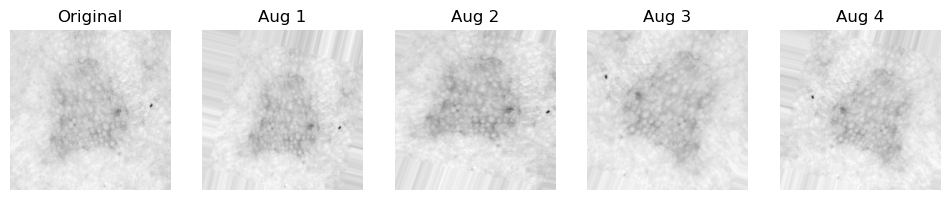

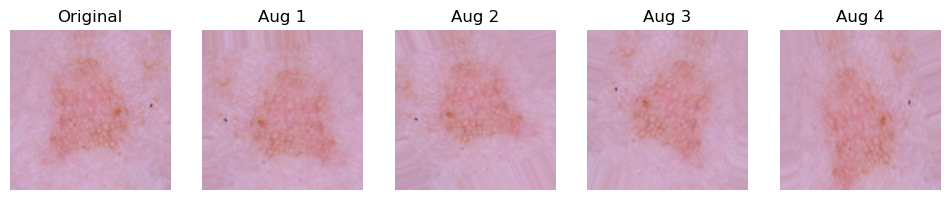

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import numpy as np
import cv2
import matplotlib.pyplot as plt


def preprocess_image(img_path, img_size=(224, 224), grayscale=False):
    img = load_img(img_path, target_size=img_size, color_mode="grayscale" if grayscale else "rgb")
    img_array = img_to_array(img)

    # Normalize to [0,1]
    img_array = img_array / 255.0

    return img_array

datagen = ImageDataGenerator(
    rotation_range=20,       # random rotation
    width_shift_range=0.1,   # horizontal shift
    height_shift_range=0.1,  # vertical shift
    zoom_range=0.2,          # zoom in/out
    horizontal_flip=True,    # flip horizontally
    fill_mode='nearest'      # filling after transformation
)

def show_augmentations(img_path, grayscale=False):

    img_array = preprocess_image(img_path, grayscale=grayscale)
    img_array = np.expand_dims(img_array, axis=0)  

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 5, 1)
    plt.imshow(img_array[0].squeeze(), cmap="gray" if grayscale else None)
    plt.title("Original")
    plt.axis("off")

    aug_iter = datagen.flow(img_array, batch_size=1)
    for i in range(4):
        aug_img = next(aug_iter)[0]
        plt.subplot(1, 5, i+2)
        plt.imshow(aug_img.squeeze(), cmap="gray" if grayscale else None)
        plt.title(f"Aug {i+1}")
        plt.axis("off")

    plt.show()

sample_img = "dataset/final/test/Actinic keratosis/ISIC_0024646.jpg"

# Show preprocessing in grayscale mode
show_augmentations(sample_img, grayscale=True)

# Show preprocessing in RGB mode
show_augmentations(sample_img, grayscale=False)

In [9]:
from tensorflow import keras
import os

DATA_DIR = r"dataset/final"

img_size = (224, 224)
batch_size = 32
seed = 42

def make_ds(split, shuffle=True):
    return keras.utils.image_dataset_from_directory(
        os.path.join(DATA_DIR, split),
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        batch_size=batch_size,
        seed=seed,
        shuffle=shuffle
    )

train_ds = make_ds("train", shuffle=True)
val_ds   = make_ds("val", shuffle=False)
test_ds  = make_ds("test", shuffle=False)

print("Classes:", train_ds.class_names)


Found 17728 files belonging to 8 classes.
Found 2529 files belonging to 8 classes.
Found 5074 files belonging to 8 classes.
Classes: ['Actinic keratosis', 'Basal cell carcinoma', 'Benign keratosis', 'Dermatofibroma', 'Melanocytic nevus', 'Melanoma', 'Squamous cell carcinoma', 'Vascular lesion']


In [10]:
from tensorflow.keras import layers
from tensorflow import keras

base_model = keras.applications.ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=img_size + (3,)
)
base_model.trainable = False   

# Build model
inputs = keras.Input(shape=img_size + (3,))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(train_ds.class_names), activation="softmax")(x)

model = keras.Model(inputs, outputs)

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │          16,392 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,604,104 (90.04 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
from tensorflow import keras

# Callbacks
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "best_resnet_model.keras",
    save_best_only=True,
    monitor="val_accuracy",
    mode="max"
)
earlystop_cb = keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=5,
    mode="max",
    restore_best_weights=True
)
# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[checkpoint_cb, earlystop_cb],
    verbose=1
)

Epoch 1/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 1383s 2s/step - accuracy: 0.4946 - loss: 1.4876 - val_accuracy: 0.5983 - val_loss: 1.1601
Epoch 2/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 1249s 2s/step - accuracy: 0.5741 - loss: 1.2111 - val_accuracy: 0.6161 - val_loss: 1.0744
Epoch 3/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 1150s 2s/step - accuracy: 0.5951 - loss: 1.1284 - val_accuracy: 0.6315 - val_loss: 1.0296
Epoch 4/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 1147s 2s/step - accuracy: 0.6102 - loss: 1.0819 - val_accuracy: 0.6390 - val_loss: 1.0058
Epoch 5/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 1164s 2s/step - accuracy: 0.6208 - loss: 1.0480 - val_accuracy: 0.6493 - val_loss: 0.9865
Epoch 6/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 1140s 2s/step - accuracy: 0.6302 - loss: 1.0147 - val_accuracy: 0.6536 - val_loss: 0.9688
Epoch 7/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 1155s 2s/step - accuracy: 0.6358 - loss: 0.9994 - val_accuracy: 0.6572 - val_loss: 0.9570
Epoch 8/10
554/554 ━━━━━━━━━━━━━━━━━━━━ 1150s 2s/step - accuracy: 0.6418 - loss: 0.9785 - 

In [21]:
best_model = keras.models.load_model("best_resnet_model.keras")
test_loss, test_acc = best_model.evaluate(test_ds, verbose=1)
print("✅ Best Model Accuracy:", test_acc, " Loss:", test_loss)

159/159 ━━━━━━━━━━━━━━━━━━━━ 382s 2s/step - accuracy: 0.6610 - loss: 0.9382
✅ Best Model Accuracy: 0.6610169410705566  Loss: 0.9381948113441467


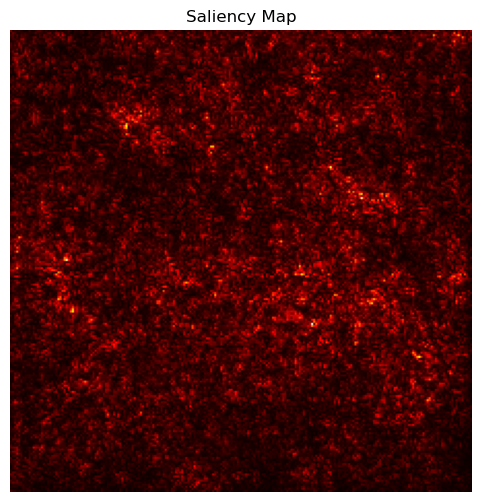

In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input

img_path = "dataset/final/test/Actinic keratosis/ISIC_0024646.jpg"
img = image.load_img(img_path, target_size=(224,224))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = preprocess_input(img_array)
img_tensor = tf.convert_to_tensor(img_array)
img_tensor = tf.cast(img_tensor, tf.float32)

with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    preds = best_model(img_tensor, training=False)
    top_class = tf.argmax(preds[0])
    loss = preds[0, top_class]
grads = tape.gradient(loss, img_tensor)
saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0]

plt.figure(figsize=(6,6))
plt.imshow(saliency, cmap='hot')
plt.axis('off')
plt.title("Saliency Map")
plt.show()

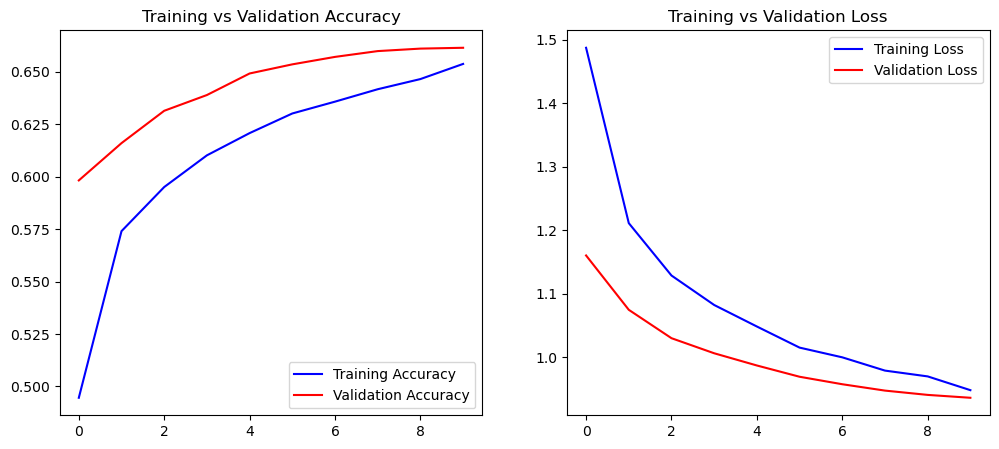

In [22]:
import matplotlib.pyplot as plt

def plot_curves(history):
    acc = history.history["accuracy"]
    val_acc = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]

    epochs = range(len(acc))

    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(epochs, acc, "b-", label="Training Accuracy")
    plt.plot(epochs, val_acc, "r-", label="Validation Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, loss, "b-", label="Training Loss")
    plt.plot(epochs, val_loss, "r-", label="Validation Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()

    plt.show()

plot_curves(history)



📊 Classification Report:

                         precision    recall  f1-score   support

      Actinic keratosis       0.46      0.11      0.18       175
   Basal cell carcinoma       0.51      0.63      0.56       665
       Benign keratosis       0.46      0.25      0.32       526
         Dermatofibroma       1.00      0.02      0.04        49
      Melanocytic nevus       0.74      0.91      0.82      2576
               Melanoma       0.59      0.46      0.52       905
Squamous cell carcinoma       0.35      0.09      0.14       127
        Vascular lesion       0.71      0.24      0.35        51

               accuracy                           0.66      5074
              macro avg       0.60      0.34      0.37      5074
           weighted avg       0.64      0.66      0.63      5074



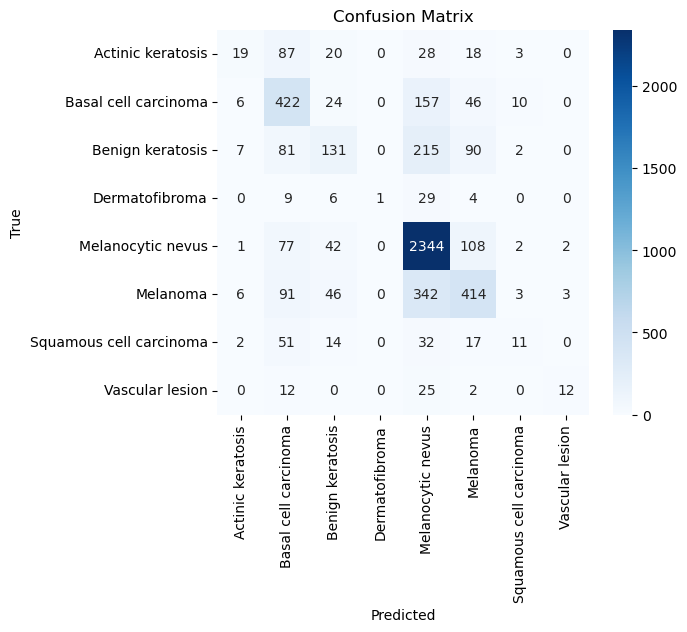

In [31]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
test_ds_eval = test_ds.unbatch().batch(32)   


y_true = []
y_pred = []

for images, labels in test_ds_eval:
    preds = best_model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

y_true = np.array(y_true)
y_pred = np.array(y_pred)

print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=test_ds.class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=test_ds.class_names,
            yticklabels=test_ds.class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [17]:
!pip install opencv-python-headless

   ---------------------------------------- 0.0/38.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/38.9 MB ? eta -:--:--
    --------------------------------------- 0.5/38.9 MB 1.2 MB/s eta 0:00:32
    --------------------------------------- 0.8/38.9 MB 1.2 MB/s eta 0:00:32
   - -------------------------------------- 1.0/38.9 MB 1.2 MB/s eta 0:00:32
   - -------------------------------------- 1.3/38.9 MB 1.2 MB/s eta 0:00:32
   - -------------------------------------- 1.6/38.9 MB 1.2 MB/s eta 0:00:32
   - -------------------------------------- 1.8/38.9 MB 1.2 MB/s eta 0:00:31
   -- ------------------------------------- 2.1/38.9 MB 1.2 MB/s eta 0:00:32
   -- ------------------------------------- 2.4/38.9 MB 1.2 MB/s eta 0:00:31
   -- ------------------------------------- 2.6/38.9 MB 1.2 MB/s eta 0:00:31
   -- ------------------------------------- 2.9/38.9 MB 1.2 MB/s eta 0:00:30
   --- ------------------------------------ 3.1/38.9 MB 1.2 MB/s eta 0:00:30
   --- ------

In [32]:
from sklearn.metrics import roc_auc_score, cohen_kappa_score
from sklearn.preprocessing import label_binarize
import numpy as np
test_ds_eval = test_ds.unbatch().batch(32)


y_true = []
for _, labels in test_ds_eval:
    y_true.extend(labels.numpy())
y_true = np.array(y_true)

y_pred_proba = best_model.predict(test_ds_eval, verbose=1)
y_pred = np.argmax(y_pred_proba, axis=1)

class_names = test_ds.class_names
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))

roc_auc_micro = roc_auc_score(y_true_bin, y_pred_proba, average="micro")
roc_auc_macro = roc_auc_score(y_true_bin, y_pred_proba, average="macro")

print(f"ROC–AUC (micro): {roc_auc_micro:.4f}")
print(f"ROC–AUC (macro): {roc_auc_macro:.4f}")

kappa = cohen_kappa_score(y_true, y_pred)
print(f"Cohen's Kappa: {kappa:.4f}")

159/159 ━━━━━━━━━━━━━━━━━━━━ 288s 2s/step
ROC–AUC (micro): 0.9368
ROC–AUC (macro): 0.8798
Cohen's Kappa: 0.4622


C:\Anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


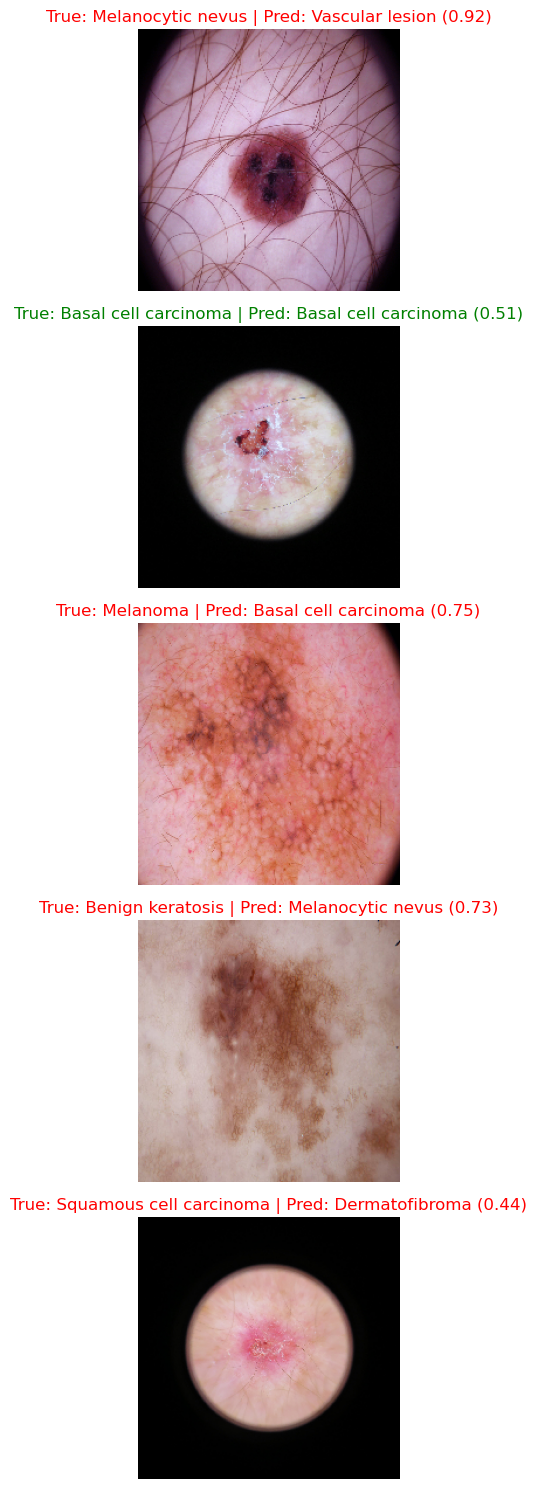

In [34]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import preprocess_input  # or EfficientNet, VGG, etc.

def show_random_predictions(test_dir, model, class_names, n=5, img_size=(224,224), use_preprocess=True):
    all_img_paths = []
    for class_name in class_names:
        class_dir = os.path.join(test_dir, class_name)
        img_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                     if f.lower().endswith((".jpg",".png",".jpeg"))]
        all_img_paths.extend(img_files)

    # Pick n random images
    sample_paths = random.sample(all_img_paths, n)

    plt.figure(figsize=(15, 3*n))

    for i, path in enumerate(sample_paths, 1):
        # Load & preprocess image
        img = keras.utils.load_img(path, target_size=img_size)
        img_array = keras.utils.img_to_array(img)[None, ...]

        if use_preprocess:
            img_array = preprocess_input(img_array)   # <- same as training
        else:
            img_array = img_array / 255.0

        # Predict
        pred = model.predict(img_array, verbose=0)
        pred_class = class_names[np.argmax(pred)]
        confidence = np.max(pred)

        # True label
        true_class = os.path.basename(os.path.dirname(path))

        # Plot
        plt.subplot(n, 1, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"True: {true_class} | Pred: {pred_class} ({confidence:.2f})",
                  color=("green" if true_class == pred_class else "red"))

    plt.tight_layout()
    plt.show()
test_dir = "dataset/final/test"
class_names = sorted(os.listdir(test_dir))   # folder names as class labels
show_random_predictions(test_dir, best_model, class_names, n=5, use_preprocess=True)


Found 5074 files belonging to 8 classes.
159/159 ━━━━━━━━━━━━━━━━━━━━ 347s 2s/step


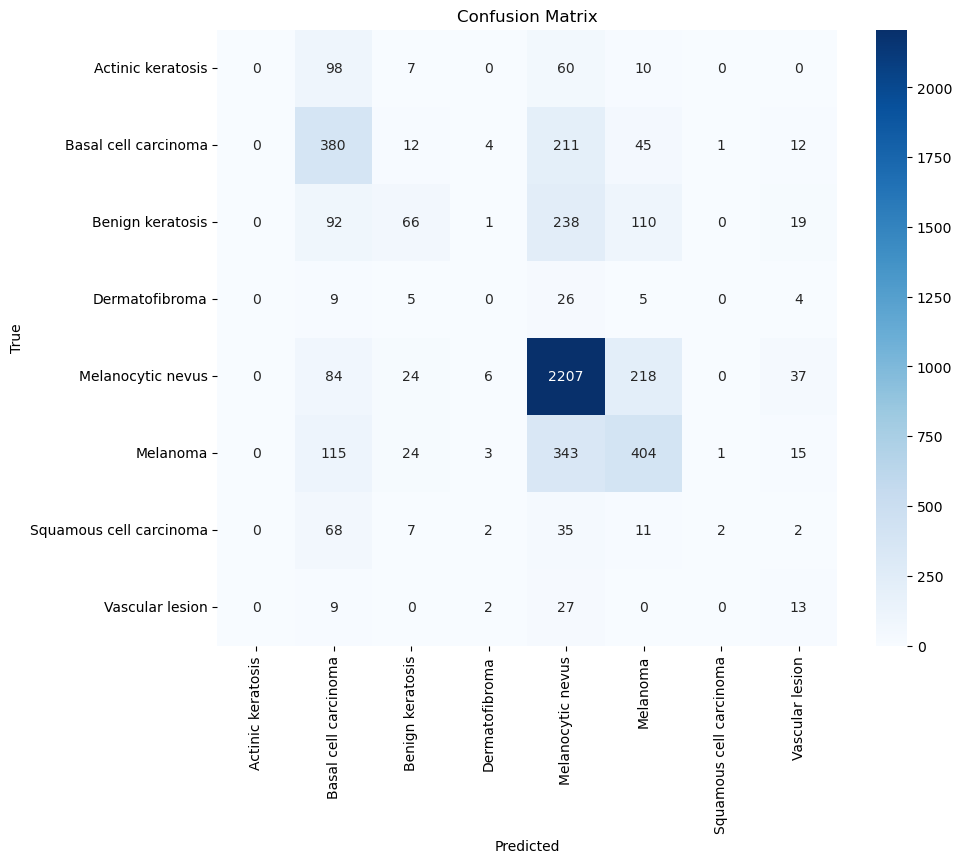


Classification Report:

                         precision    recall  f1-score   support

      Actinic keratosis       0.00      0.00      0.00       175
   Basal cell carcinoma       0.44      0.57      0.50       665
       Benign keratosis       0.46      0.13      0.20       526
         Dermatofibroma       0.00      0.00      0.00        49
      Melanocytic nevus       0.70      0.86      0.77      2576
               Melanoma       0.50      0.45      0.47       905
Squamous cell carcinoma       0.50      0.02      0.03       127
        Vascular lesion       0.13      0.25      0.17        51

               accuracy                           0.61      5074
              macro avg       0.34      0.28      0.27      5074
           weighted avg       0.57      0.61      0.56      5074



C:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [36]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model_fast(test_dir, model, img_size=(224,224), batch_size=32):
    # Create test dataset
    test_ds = tf.keras.utils.image_dataset_from_directory(
        test_dir,
        labels="inferred",
        label_mode="int",
        image_size=img_size,
        shuffle=False,   
        batch_size=batch_size
    )

    class_names = test_ds.class_names
    test_ds = test_ds.map(lambda x, y: (tf.keras.applications.resnet50.preprocess_input(x), y))

    y_pred_proba = model.predict(test_ds, verbose=1)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = np.concatenate([y for x, y in test_ds], axis=0)

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt="d", 
                xticklabels=class_names, 
                yticklabels=class_names, 
                cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

    print("\nClassification Report:\n")
    print(classification_report(y_true, y_pred, target_names=class_names))

test_dir = "dataset/final/test"
evaluate_model_fast(test_dir, best_model)


In [39]:
import random
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import preprocess_input  

def show_only_correct_predictions(test_dir, model, class_names, n=5, img_size=(224,224), use_preprocess=True):
    all_img_paths = []
    for class_name in class_names:
        class_dir = os.path.join(test_dir, class_name)
        img_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                     if f.lower().endswith((".jpg",".png",".jpeg"))]
        all_img_paths.extend(img_files)

    correct_images = []
    for path in all_img_paths:
        img = keras.utils.load_img(path, target_size=img_size)
        img_array = keras.utils.img_to_array(img)[None, ...]

        if use_preprocess:
            img_array = preprocess_input(img_array)
        else:
            img_array = img_array / 255.0

        pred = model.predict(img_array, verbose=0)
        pred_class = class_names[np.argmax(pred)]
        confidence = np.max(pred)

        true_class = os.path.basename(os.path.dirname(path))

        if true_class == pred_class:
            correct_images.append((img, true_class, pred_class, confidence))

        if len(correct_images) >= n:
            break
    plt.figure(figsize=(15, 3*n))
    for i, (img, true_class, pred_class, confidence) in enumerate(correct_images, 1):
        plt.subplot(n, 1, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"✅ True: {true_class} | Pred: {pred_class} ({confidence:.2f})", color="green")

    plt.tight_layout()
    plt.show()


C:\Users\VSR BALASUBRAHMANYAM\AppData\Local\Temp\ipykernel_3084\1172147365.py:52: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


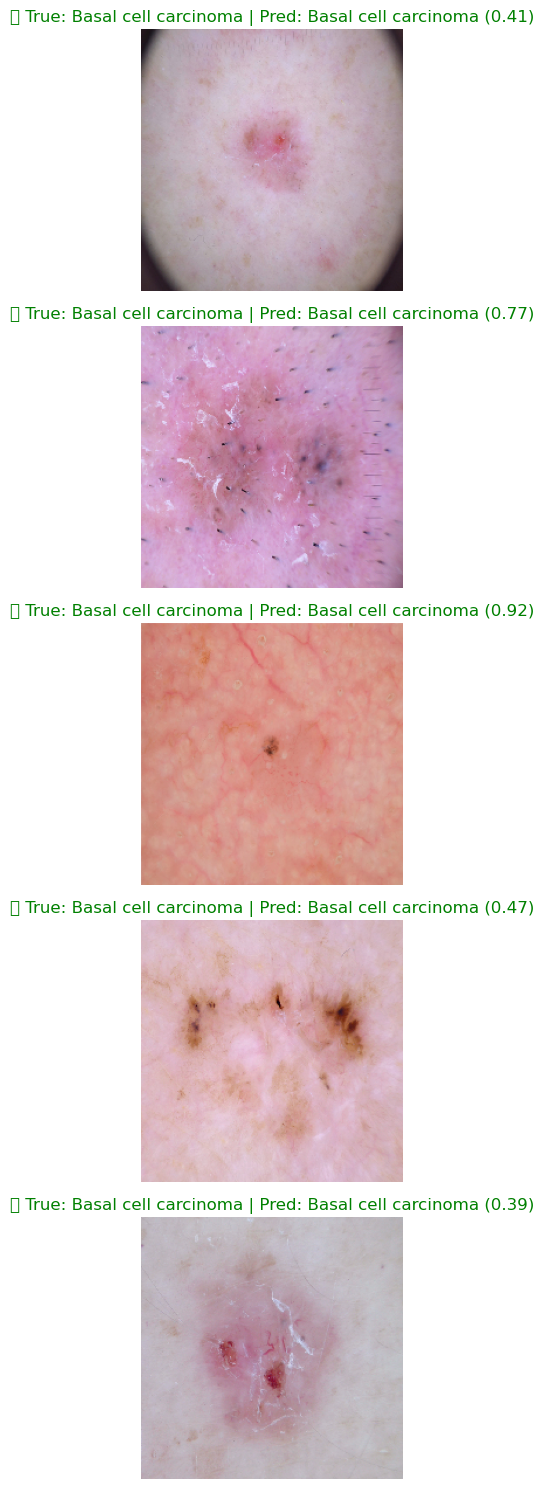

In [40]:
test_dir = "dataset/final/test"
class_names = sorted(os.listdir(test_dir))  
show_only_correct_predictions(test_dir, best_model, class_names, n=5, use_preprocess=True)

In [43]:
def show_only_correct_predictions(test_dir, model, class_names, n=5, img_size=(224,224), use_preprocess=True):
    all_img_paths = []
    for class_name in class_names:
        class_dir = os.path.join(test_dir, class_name)
        img_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) 
                     if f.lower().endswith((".jpg",".png",".jpeg"))]
        all_img_paths.extend(img_files)

    correct_images = []

    for path in all_img_paths:
        img = keras.utils.load_img(path, target_size=img_size)
        img_array = keras.utils.img_to_array(img)[None, ...]

        if use_preprocess:
            img_array = preprocess_input(img_array)
        else:
            img_array = img_array / 255.0

        pred = model.predict(img_array, verbose=0)
        pred_class = class_names[np.argmax(pred)]
        confidence = np.max(pred)
        true_class = os.path.basename(os.path.dirname(path))

        if true_class == pred_class:
            correct_images.append((img, true_class, pred_class, confidence))

    if not correct_images:
        print("⚠️ No correct predictions found.")
        return
    sample = random.sample(correct_images, min(n, len(correct_images)))

    plt.figure(figsize=(15, 3*len(sample)))
    for i, (img, true_class, pred_class, confidence) in enumerate(sample, 1):
        plt.subplot(len(sample), 1, i)
        plt.imshow(img)
        plt.axis("off")
        plt.title(f"✅ True: {true_class} | Pred: {pred_class} ({confidence:.2f})", color="green")

    plt.tight_layout()
    plt.show()


C:\Users\VSR BALASUBRAHMANYAM\AppData\Local\Temp\ipykernel_3084\1796284914.py:42: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


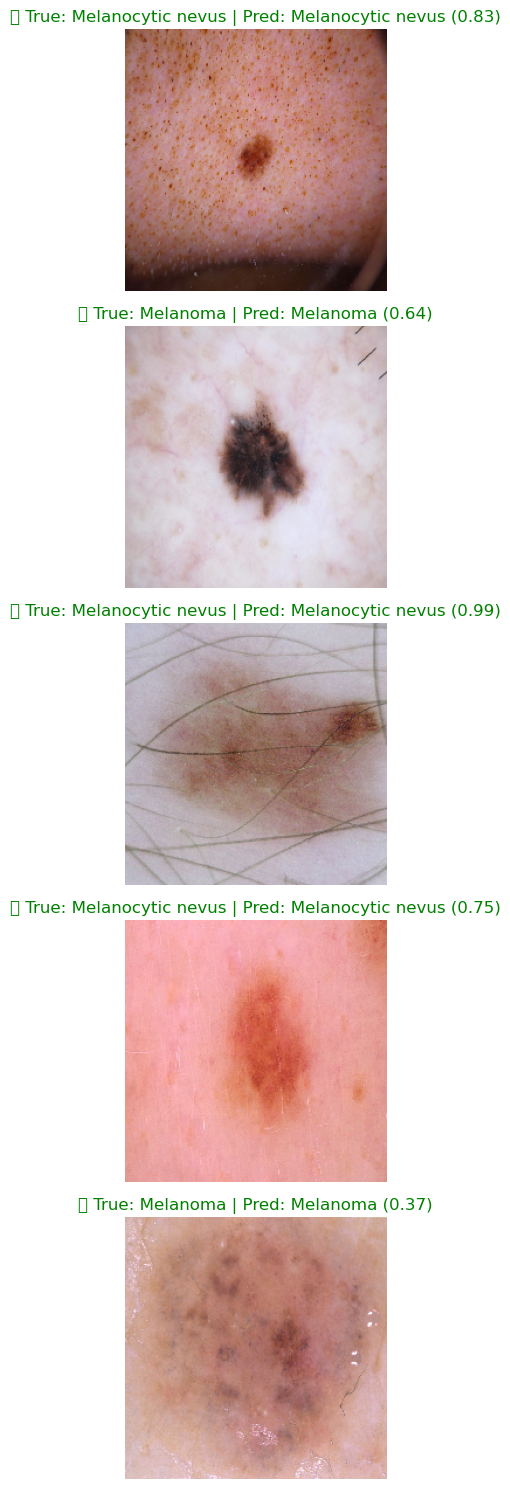

In [44]:
test_dir = "dataset/final/test"
class_names = sorted(os.listdir(test_dir))
show_only_correct_predictions(test_dir, best_model, class_names, n=5)


Found 5075 files belonging to 8 classes.
159/159 ━━━━━━━━━━━━━━━━━━━━ 337s 2s/step


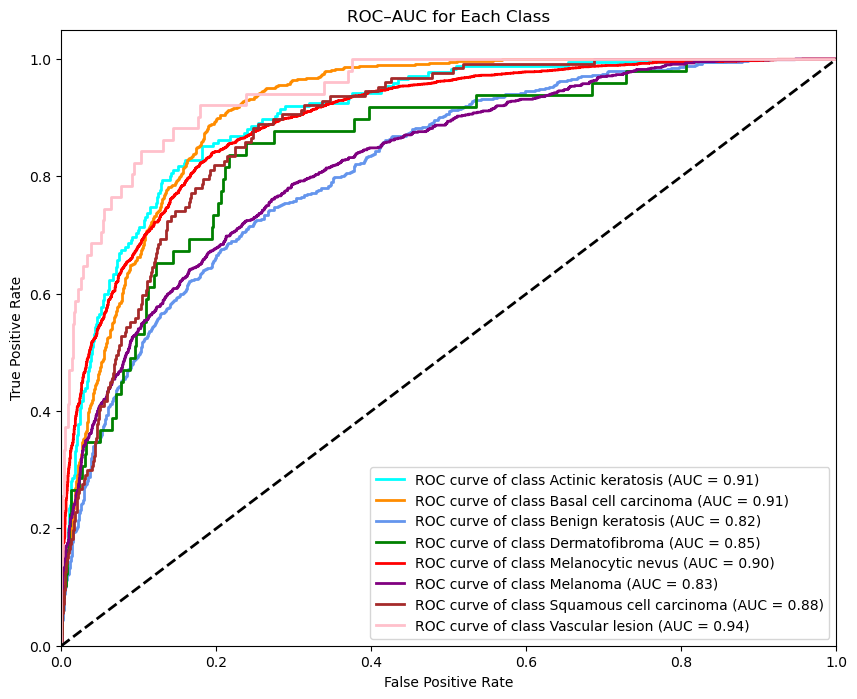

In [15]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

test_dataset = tf.keras.utils.image_dataset_from_directory(
    "dataset/final/test",
    image_size=(224, 224),
    batch_size=32,
    shuffle=False
)

class_names = test_dataset.class_names
num_classes = len(class_names)

y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
y_true_bin = label_binarize(y_true, classes=range(num_classes))

y_pred = best_model.predict(test_dataset, verbose=1)

def plot_multiclass_roc(y_true_bin, y_pred, class_names):
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])

    for i, color in zip(range(len(class_names)), colors):
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color=color, lw=2,
                 label=f"ROC curve of class {class_names[i]} (AUC = {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], "k--", lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC–AUC for Each Class")
    plt.legend(loc="lower right")
    plt.show()

plot_multiclass_roc(y_true_bin, y_pred, class_names)


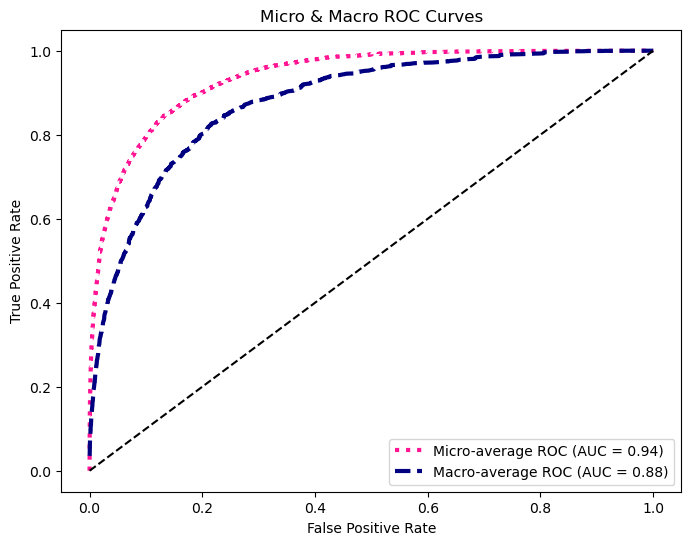

In [16]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
import matplotlib.pyplot as plt
import numpy as np

fpr_micro, tpr_micro, _ = roc_curve(y_true_bin.ravel(), y_pred.ravel())
roc_auc_micro = auc(fpr_micro, tpr_micro)
all_fpr = np.unique(np.concatenate([roc_curve(y_true_bin[:, i], y_pred[:, i])[0] for i in range(len(class_names))]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(len(class_names)):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred[:, i])
    mean_tpr += np.interp(all_fpr, fpr, tpr)
mean_tpr /= len(class_names)
roc_auc_macro = auc(all_fpr, mean_tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr_micro, tpr_micro, label=f"Micro-average ROC (AUC = {roc_auc_micro:.2f})", color="deeppink", linestyle=":", linewidth=3)
plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {roc_auc_macro:.2f})", color="navy", linestyle="--", linewidth=3)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Micro & Macro ROC Curves")
plt.legend(loc="lower right")
plt.show()

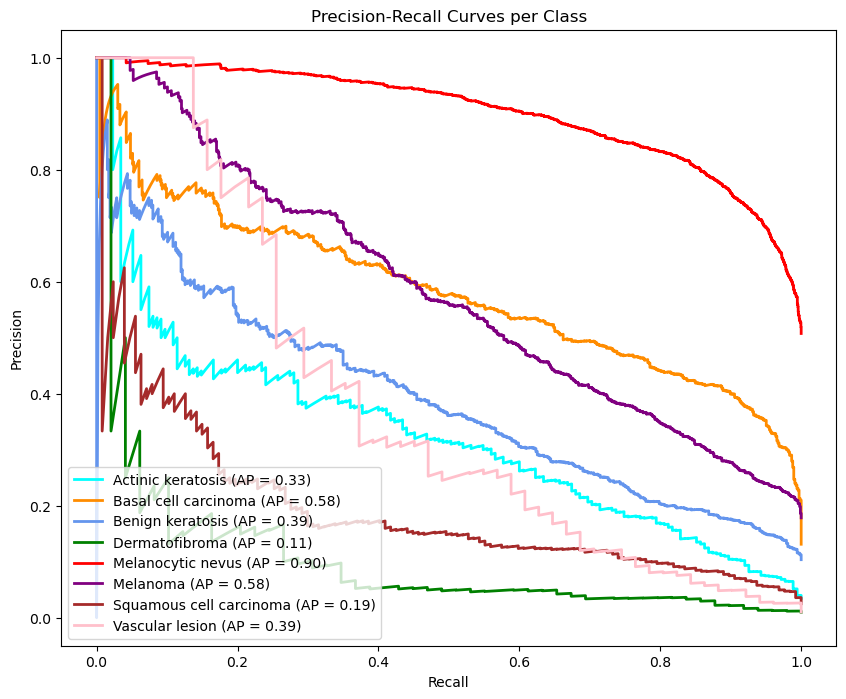

In [17]:
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'brown', 'pink'])

for i, color in zip(range(len(class_names)), colors):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred[:, i])
    ap = average_precision_score(y_true_bin[:, i], y_pred[:, i])
    plt.plot(recall, precision, color=color, lw=2, label=f"{class_names[i]} (AP = {ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves per Class")
plt.legend(loc="lower left")
plt.show()


In [18]:
import tensorflow as tf

top2_acc = tf.keras.metrics.top_k_categorical_accuracy(
    tf.keras.utils.to_categorical(y_true, num_classes=len(class_names)),
    y_pred,
    k=2
)
top3_acc = tf.keras.metrics.top_k_categorical_accuracy(
    tf.keras.utils.to_categorical(y_true, num_classes=len(class_names)),
    y_pred,
    k=3
)

print(f"Top-2 Accuracy: {np.mean(top2_acc):.4f}")
print(f"Top-3 Accuracy: {np.mean(top3_acc):.4f}")


Top-2 Accuracy: 0.8343
Top-3 Accuracy: 0.9125


In [43]:
best_model.summary()
print(f"\n🔢 Total trainable parameters: {best_model.count_params():,}")

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8)                   │          16,392 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,636,890 (90.17 MB)

 Trainable params: 16,392 (64.03 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 32,786 (128.07 KB)


🔢 Total trainable parameters: 23,604,104


In [58]:
import pandas as pd
y_true_flat = y_true.ravel()
y_pred_flat = y_pred.ravel()

errors = []
for true, pred in zip(y_true_flat, y_pred_flat):
    if true != pred:
        errors.append((class_names[int(true)], class_names[int(pred)]))
error_df = pd.DataFrame(errors, columns=["True Class", "Predicted Class"])

print("\n❌ Sample Misclassifications:")
print(error_df.value_counts().head(10))  # top 10 confusions



❌ Sample Misclassifications:
True Class               Predicted Class  
Melanocytic nevus        Actinic keratosis    2576
Melanoma                 Actinic keratosis     905
Basal cell carcinoma     Actinic keratosis     666
Benign keratosis         Actinic keratosis     526
Actinic keratosis        Actinic keratosis     175
Squamous cell carcinoma  Actinic keratosis     127
Vascular lesion          Actinic keratosis      51
Dermatofibroma           Actinic keratosis      49
Name: count, dtype: int64
